# Funktionen Piringer Modell 

## Model functions

In [317]:
def get_material_data(material):
    # Datenbankabfrage hier noch erweiterbaR
    # material_parameter = worst case
    material_parameters = {
        "LDPE": {"A_Pt": 11.7, "tau": 0},
        # "LDPE": {"A_Pt": 11.5, "tau": 0}, #  von AKTS
        "HDPE": {"A_Pt": 13.2, "tau": 1577},
        # "HDPE": {"A_Pt": 11.9, "tau": 1577}, # für Validierung
        "LLDPE": {"A_Pt": 11.5, "tau": 0},
        # "LLDPE": {"A_Pt": 9.8, "tau": 0}, # für Validierung
        "PP": {"A_Pt": 12.4, "tau": 1577},
        "PET": {"A_Pt": 6.35, "tau": 1577},
        "PS": {"A_Pt": -0.7, "tau": 0},
        "PEN": {"A_Pt": 3.7, "tau": 1577},
        "HIPS": {"A_Pt": 0.1, "tau": 0}
    }

    material_parameters_best_case = {
        "LDPE": {"A_Pt": 10.0, "tau": 0},
        "HDPE": {"A_Pt": 10.0, "tau": 1577},
        # "LLDPE": {"A_Pt": 11.5, "tau": 0},
        "PP": {"A_Pt": 9.4, "tau": 1577},
        "PET": {"A_Pt": 2.2, "tau": 1577},
        "PS": {"A_Pt": -2.8, "tau": 0},
        "PEN": {"A_Pt": -0.34, "tau": 1577},
        "HIPS": {"A_Pt": -2.7, "tau": 0}
    }

    if material in material_parameters:
        return material_parameters[material]
    else:
        raise ValueError("Unbekanntes Material")

def diffusion_coefficient_Piringer(M_mw, T_C, material_params):
    A_Pt, tau = material_params['A_Pt'], material_params['tau']
    T = 273.15 + T_C  # Temperatur in K
    M_r = 12 * (M_mw / 12)  # relative Molekülmasse des Migranten (Da) 
    R = 8.3145  # Gaskonstante (J/(mol*K))
    E_A = (10454 + tau) * R  # Diffusionsaktivierungsenergie
    A_P = A_Pt - (tau / T)
    D_0 = 1e4  # D_0 nach Piringer Modell 
    if M_r <= 4000: 
        return D_0 * np.exp(A_P - 0.1351 * M_r**(2 / 3) + 0.003 * M_r - (10454 * R / (R * T)))  # Diffusionskoeffizient in [cm^2/s] (nach Pirigner)
    else: 
        raise ValueError("M_r über 4000 Dalton, andere Berechnung von D_P nötig!")

def calculate_migration_timestep(D_P, c_t, P_density, F_density, K_PF, t_step, V_P, V_F, d_P, d_F, A_PF):
    alpha = (1 / K_PF) * (d_F / d_P)  # Dimensionlöse Größe alpha
    # upper_alpha = 3
    # lower_alpha = 0.001
    # def calculate_q_n(n, alpha):
    #     if alpha < lower_alpha:
    #         return n * np.pi / (1 + alpha)
    #     else:
    #         return (n - (alpha / (2 * (1 + alpha)))) * np.pi

    upper_alpha = 100
    def calculate_q_n(n, alpha):
        if alpha < 0.001:
            return n * np.pi / (1 + alpha)
        elif alpha > upper_alpha:
            return (2 * n - 1) * np.pi / 2
        else:
            return (n - (alpha / (2 * (1 + alpha)))) * np.pi

    sum_a = 0   # Anfang der Summe
    k = 1       # Summand k
    while True:
        q_n = calculate_q_n(k, alpha)
        # sum_term_i = (2 * alpha * (1 + alpha)) / (1 + alpha + alpha**2 * q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
        # sum_term_i = (2 / q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
        
        
        if alpha > upper_alpha:
            sum_term_i = (2 / q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
        else:
            sum_term_i = (2 * alpha * (1 + alpha)) / (1 + alpha + alpha**2 * q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
            
        sum_before = sum_a
        sum_a += sum_term_i
        
        # Terminierung der unendlichen Summe
        if abs(sum_a - sum_before) < 1e-6:
            break
        k += 1

        
    # migration_amount = c_t * P_density * d_P  * (1 - sum_a)
    # migration_amount = c_t * P_density * d_P * (alpha / (1 + alpha)) * (1 - sum_a)
        
    # Berechnet Migrationsmenge zu dem Zeitpunkt t_step und Fallunterscheidung abhängig von alpha
    if alpha > upper_alpha: 
        migration_amount = c_t * P_density * d_P  * (1 - sum_a)
    else:
        migration_amount = c_t * P_density * d_P * (alpha / (1 + alpha)) * (1 - sum_a)

    # Verhindert negative Konzentrationen
    if migration_amount < 0: 
        migration_amount = 0
        
    return migration_amount

def migrationsmodell_piringer(M_mw, T_C, c_P0, Material, P_density, F_density, K_PF, max_time, V_P, V_F, d_P, d_F, A_PF, timestep):
    material_params = get_material_data(Material)
    # Eingabe Diffusionskoeffizient
    D_P = diffusion_coefficient_Piringer(M_mw, T_C, material_params)
    migration_data = []
    current_time = 0
    while current_time < max_time:
        migration_amount = calculate_migration_timestep(D_P, c_P0, P_density, F_density, K_PF, current_time, V_P, V_F, d_P, d_F, A_PF)
        # Umrechnung in mg/dm^2
        migration_amount_area = migration_amount / 10
        migration_data.append(migration_amount_area)
        current_time += timestep

    return migration_data 


## Utility functions

In [318]:
def calculate_max_cp0(SML, M_mw, T_C, Material, P_density, F_density, K_PF, max_time, V_P, V_F, d_P, d_F, A_PF, timestep):
    # Set an initial guess for c_P0
    c_P0_guess = 20  # Start with 1 mg/kg
    tolerance = 1e-6  # Tolerance for the solution
    max_iterations = 300  # Set a max number of iterations
    
    for _ in range(max_iterations):
        # Berechne die Migration für den aktuellen c_P0-Schätzwert
        migration_data = migrationsmodell_piringer(M_mw, T_C, c_P0_guess, Material, P_density, F_density, K_PF, max_time, V_P, V_F, d_P, d_F, A_PF, timestep)
        
        # Berechne die maximale Migration
        migration_max = max(migration_data)  # max migration 
        
        # Check if the calculated SML meets the target SML within the tolerance
        if abs(migration_max - SML) < tolerance:
            return c_P0_guess
        
        # Anpassung von c_P0 basierend auf dem Verhältnis zwischen aktueller Migration und Ziel-SML
        c_P0_guess *= (SML / migration_max)
    
    # Wenn keine Konvergenz erreicht wird
    raise ValueError("Maximale Iterationen erreicht, keine Lösung gefunden")


# Imports und Parameterdefinition

In [319]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# Physikalisch-chemische Eigenschaften
M_mw = 136              # [g/mol]       Molekulargewicht Migrant
T_C = 20                # [°C]          Temperatur
c_P0 = 1000            # [mg/kg]       Anfangskonzentration im Polymer
Material = "LDPE"       # [-]           Material Polymer
P_density = 0.9175           # [g/cm^3]      Dichte Polymer
F_density = 0.9           # [g/cm^3]      Dichte Fluid
K_PF = 1                # [-]           Verteilungskoeffizient
max_time=3600 * 24 * 100   # [s]           Simulationszeit (Sekunden/Stunde * Stunden/Tag * Tag)

# Geometrische Größen
d_P = 0.2                # [cm]          Durchmesser des Polymers
d_F = 1.85                 # [cm]          Durchmesser des Fluids 
V_P = None                   # [cm^3]        Volumen Polymer
V_F = None                  # [cm^3]        Volumen Fluid
A_PF = 6                  # [dm^2]        Kontaktfläche Polymer/Fluid

# Modellparameter nach Piringer
timestep = 3600    # [s]           Schrittweite 
time_days = np.arange(0, max_time / (3600 * 24), timestep / (3600 * 24))

alpha = (1 / K_PF) * (d_F / d_P)
material_data = get_material_data(Material)  
A_Pt = material_data["A_Pt"]  


# Moderllierungsergebnisse 

## Migrationskurve

In [320]:
results_area = migrationsmodell_piringer(M_mw, T_C, c_P0, Material, 
                                             P_density, F_density, K_PF, max_time, V_P, V_F, 
                                             d_P, d_F, A_PF, timestep)

### Speichern der Ergebnisse

In [321]:
# np.save("/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/data/Modellvergleich/Piringer-vergleich-100days-LDPE", results_area)

In [322]:
# # Plot the area-specific migration results
# plt.figure(figsize=(10, 6))
# plt.plot(time_days, results_area)
# # # Unterschrift mit den Randbedingungen
# # conditions_text = (
# #     f"Material: {Material} \n"
# #     f"$T$ = {T_C} °C, $M_{{r}}$ = {M_mw} g/mol, $A_{{P}}^{{'}}$ = {A_Pt} \n"
# #     f"$c_{{P,0}}$ = {c_P0} mg/kg, $\\rho_{{P}}$ = {P_density} g/cm³, $\\rho_{{F}}$ = {F_density} g/cm³\n"
# #     f"$K_{{P,F}}$ = {K_PF}, $\\alpha$ = {alpha}\n"
# #     f"$A_{{P,F}}$ = {A_PF} dm², $d_{{P}}$ = {d_P} cm, $d_{{F}}$ = {d_F} cm\n"
# # )
# # Füge den Text unterhalb des Plots hinzu
# # plt.figtext(0.75, 0.15, conditions_text, wrap=True, horizontalalignment='center', fontsize=10)
# plt.title("Area-specific Migration over Time")
# plt.xlabel("Time $[days]$")
# plt.ylabel("Migrating amount $[mg/dm^2]$")
# plt.show()

## Berechnung der Anfangskonzentration um SML nicht zu überschreiten

In [323]:
# SML_rinse_off = 1.665  # z.B. 1,665 mg/dm² für 0,01 % Konzentration von Limonen für Rinse Off
# max_cp0 = calculate_max_cp0(SML_rinse_off, M_mw, T_C, Material, P_density, F_density, K_PF, max_time, V_P, V_F, d_P, d_F, A_PF, timestep)
# print(f"Maximale Anfangskonzentration, um SML bei {max_time/(3600*24):.2f} Tagen nicht zu überschreiten: {max_cp0} mg/kg")

# SML_leave_on= 0.1665  # z.B. 1,665 mg/dm² für 0,01 % Konzentration von Limonen für Rinse Off
# max_cp0 = calculate_max_cp0(SML_leave_on, M_mw, T_C, Material, P_density, F_density, K_PF, max_time, V_P, V_F, d_P, d_F, A_PF, timestep)
# print(f"Maximale Anfangskonzentration, um SML bei {max_time/(3600*24):.2f} Tagen nicht zu überschreiten: {max_cp0} mg/kg")

In [324]:
# # Plot the area-specific migration results
# plt.figure(figsize=(10, 6))
# time_days = np.arange(0, max_time / (3600 * 24), timestep / (3600 * 24))
# plt.plot(time_days, results_area)
# # # Unterschrift mit den Randbedingungen
# # conditions_text = (
# #     f"Material: {Material} \n"
# #     f"$T$ = {T_C} °C, $M_{{r}}$ = {M_mw} g/mol, $A_{{P}}^{{'}}$ = {A_Pt} \n"
# #     f"$c_{{P,0}}$ = {c_P0} mg/kg, $\\rho_{{P}}$ = {P_density} g/cm³, $\\rho_{{F}}$ = {F_density} g/cm³\n"
# #     f"$K_{{P,F}}$ = {K_PF}, $\\alpha$ = {alpha}\n"
# #     f"$A_{{P,F}}$ = {A_PF} dm², $d_{{P}}$ = {d_P} cm, $d_{{F}}$ = {d_F} cm\n"
# # )
# # Füge den Text unterhalb des Plots hinzu
# # plt.figtext(0.75, 0.15, conditions_text, wrap=True, horizontalalignment='center', fontsize=10)
# plt.axhline(y=SML_rinse_off, color='r', linestyle='--', label=f'SML_{{rinse-off}} = {SML_rinse_off} $mg/dm^2$')
# plt.title("Area-specific Migration over Time")
# plt.xlabel("Time $[days]$")
# plt.ylabel("Migrating amount $[mg/dm^2]$")
# plt.show()

## Einfluss der Temperatur

In [325]:
# results_area_T = []

# # Variation der Tempeartur
# temperatures = np.arange(20, 81, 1)
# for T_C in temperatures:
#     migration_data = migrationsmodell_piringer(M_mw, T_C, c_P0, Material, 
#                                              P_density, F_density, K_PF, max_time, V_P, V_F, 
#                                              d_P, d_F, A_PF, timestep) 
#     results_area_T.append(migration_data)

# # Flächenbezogene Migration
# # Umrechnung in [mg/dm^2]
# results_area_T = np.array(results_area_T)

# # Umrechnung in prozentuale Migration 
# results_percent_T = np.array(results_area_T) / (P_density * c_P0 * d_P)
# results_percent_T = results_percent_T.tolist()  # [%]

# # Umrechnung in flächenunspezifische Migration
# results_T = np.array(results_area_T) * A_PF  # [mg/kg]
# results_T = results_T.tolist()


## Einfluss des Molekülgewichts

In [326]:
# results_area_M_mw = []

# # Variation der molekularen Masse    
# molecularweights = np.arange(100, 600, 10)    
# for M_mw in molecularweights:
#     migration_data = migrationsmodell_piringer(M_mw, T_C, c_P0, Material, 
#                                              P_density, F_density, K_PF, max_time, V_P, V_F, 
#                                              d_P, d_F, A_PF, timestep) 
#     results_area_M_mw.append(migration_data)

# # Flächenbezogene Migration
# # Umrechnung in [mg/dm^2]
# results_area_M_mw = np.array(results_area_M_mw) 
# results_area_M_mw = results_area_M_mw.tolist()

# # Umrechnung in prozentuale Migration 
# results_percent_M_mw = np.array(results_area_M_mw) / (P_density * c_P0 * d_P)
# results_percent_M_mw = results_percent_M_mw.tolist()  # [%]

# # Umrechnung in flächenunspezifische Migration
# results_M_mw = np.array(results_area_M_mw) * A_PF  # [mg/kg]
# results_M_mw = results_M_mw.tolist()


## Einfluss des Materials

Dichten aus [OJE13] gemittelt (Polymers and the Environment)

In [327]:
# materials = {
#     'LDPE': 0.9175,  # [g/cm^3]
#     'HDPE': 0.955,   # [g/cm^3]
#     'PP': 0.9045,    # [g/cm^3]
#     'PET': 1.35,      # [g/cm^3]
#     'PS': 1.06      # [g/cm^3]
# }

# results_area_material = []
# for material, P_density in materials.items():
#     migration_data = migrationsmodell_piringer(M_mw, T_C, c_P0, material, 
#                                                P_density, F_density, K_PF, max_time, 
#                                                V_P, V_F, d_P, d_F, A_PF, timestep) 
#     results_area_material.append(migration_data)
    
    
# # Flächenbezogene Migration
# # Umrechnung in [mg/dm^2]
# results_area_material = np.array(results_area_material)

# # Umrechnung in prozentuale Migration 
# results_percent_material = np.array(results_area_material) / (P_density * c_P0 * d_P)
# results_percent_material = results_percent_material.tolist()  # [%]

# # Umrechnung in flächenunspezifische Migration
# results_material = np.array(results_area_material) * A_PF  # [mg/kg]
# results_material = results_material.tolist()


## Einfluss des Verteilungskoeffizienten 

In [328]:
K_values = [0.1, 1, 10, 100, 1000]

results_area_K = []
for K_PF in K_values:
    migration_data = migrationsmodell_piringer(M_mw, T_C, c_P0, Material, 
                                             P_density, F_density, K_PF, max_time, V_P, V_F, 
                                             d_P, d_F, A_PF, timestep) 
    results_area_K.append(migration_data)
    


# Umrechnung in prozentuale Migration 
results_percent_K = np.array(results_area_K) / (P_density * c_P0 * d_P)
results_percent_K = results_percent_K.tolist()  # [%]

# Umrechnung in flächenunspezifische Migration
results_K = np.array(results_area_K) * A_PF  # [mg/kg]
results_K = results_K.tolist()

## Einlfuss der Schichtdicke des Polymers

In [329]:
# results_area_d_P = []

# # Variation der Tempeartur
# d_P_values = np.arange(0.002, 81, 5)
# for T_C in temperatures:
#     migration_data = migrationsmodell_piringer(M_mw, T_C, c_P0, Material, 
#                                              P_density, F_density, K_PF, max_time, V_P, V_F, 
#                                              d_P, d_F, A_PF, timestep) 
#     results_area_T.append(migration_data)

# # Flächenbezogene Migration
# # Umrechnung in [mg/dm^2]
# results_area_T = np.array(results_area_T) / 10
# results_area_T = results_area_T.tolist()

# # Umrechnung in prozentuale Migration 
# results_percent_T = np.array(results_area_T) / (P_density * c_P0 * d_P)
# results_percent_T = results_percent_T.tolist()  # [%]

# # Umrechnung in flächenunspezifische Migration
# results_T = np.array(results_area_T) * A_PF  # [mg/kg]
# results_T = results_T.tolist()


# Plot-Konfiguration

## 3D-Plot Konfiguration

### Einfluss der Temperatur

In [330]:
# # # colors = ["#00349D", "#1F78B4", "#A6CEE3", "#FDBF6F", "#F06D1D"]  
# # # colors = ["#00349D", "#0059B3", "#007FCB", "#F28E2B", "#F06D1D"]
# # # colors = ["#00349D", "#577CAD", "#A1BEDD", "#F9B676", "#F06D1D"]
# # # colors = ["#00349D", "#1B61A8", "#4CA8C5", "#F7A959", "#F06D1D"]
# # # colors = ["#00349D", "#006DBF", "#66A4DC", "#FDA057", "#F06D1D"]
# # colors = ["#00349D", "#3A6FB5", "#90BADF", "#F6A965", "#F06D1D"]

# colors = ["#00349D", "#0061A5", "#218AB7", "#60B1C8", "#A6D3DD", 
#           "#F1D6A6", "#F7A95A", "#F3782E", "#F06D1D"]

# n_bins = 100  # Anzahl der Zwischenstufen

# # Erstelle die benutzerdefinierte Colormap
# custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

# # Umwandlung der Daten für den 3D-Plot
# X, Y = np.meshgrid(time_days, temperatures)
# Z = np.array(results_area_T)

# # Erstellen des 3D-Plots
# fig = plt.figure(figsize=(16, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Plotten der Oberfläche mit der benutzerdefinierten Colormap
# surf = ax.plot_surface(X, Y, Z, cmap=custom_cmap, edgecolor='none')

# # Achsen
# ax.view_init(elev=20, azim=-110)
# ax.set_xlabel('Zeit $[Tage]$', fontsize=13)
# ax.set_ylabel('Temperatur $[°C]$',  fontsize=13)
# ax.set_zlabel('')
# # Manuelles Hinzufügen der Beschriftung an einer spezifischen Position
# ax.text2D(0.04, 0.55, 'spez. Migrationsmenge $[mg/dm^2]$', 
#           transform=ax.transAxes, 
#           rotation=90, 
#           ha='center', 
#           va='center', 
#           fontsize = 13)

# ax.tick_params(axis='both', which='major', labelsize=12)  # Achsen-Tick-Zahlen für X- und Y-Achse
# ax.tick_params(axis='z', which='major', labelsize=12)     # Achsen-Tick-Zahlen für Z-Achse

# # Farblegende
# cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, pad=-0.01)
# cbar.set_label('$[mg/dm^2]$', fontsize=13)
# cbar.ax.tick_params(labelsize=12)

# # Layout anpassen und Plot anzeigen
# plt.tight_layout()
# plt.subplots_adjust(left=0.2, right=0.95)
# plt.savefig('/Users/tomhartmann/Documents/00_UNI/01_MASTER/STUDIENARBEIT/000_Vektorgrafiken/Piringer/piringer-var-t-2-colormap.pdf', bbox_inches='tight')
# plt.show()


### Einfluss des Molekülgewichts des Migranten

In [331]:
# # Definiere die individuellen Farben für die Colormap
# colors = ["#00349D", "#0061A5", "#218AB7", "#60B1C8", "#A6D3DD", 
#           "#F1D6A6", "#F7A95A", "#F3782E", "#F06D1D"]
# n_bins = 100  # Anzahl der Zwischenstufen

# # Erstelle die benutzerdefinierte Colormap
# custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

# # Umwandlung der Daten für den 3D-Plot
# X, Y = np.meshgrid(time_days, molecularweights)
# Z = np.array(results_area_M_mw)

# # Erstellen des 3D-Plots
# fig = plt.figure(figsize=(16, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Plotten der Oberfläche mit der benutzerdefinierten Colormap
# surf = ax.plot_surface(X, Y, Z, cmap=custom_cmap, edgecolor='none')

# # Achsen
# ax.view_init(elev=20, azim=-110)
# ax.set_xlabel('Zeit $[Tage]$', fontsize=13)
# ax.set_ylabel('Molekülmasse $[g/mol]$',  fontsize=13)
# ax.invert_yaxis()  # Y-Achse umkehren
# ax.set_zlabel('')
# # Manuelles Hinzufügen der Beschriftung an einer spezifischen Position
# ax.text2D(0.04, 0.55, 'spez. Migrationsmenge $[mg/dm^2]$', 
#           transform=ax.transAxes, 
#           rotation=90, 
#           ha='center', 
#           va='center', 
#           fontsize = 13)

# # Position des 3D-Plots anpassen
# ax.set_position([0.2, 0.1, 1, 1])  # [left, bottom, width, height]

# ax.tick_params(axis='both', which='major', labelsize=12)  # Achsen-Tick-Zahlen für X- und Y-Achse
# ax.tick_params(axis='z', which='major', labelsize=12)     # Achsen-Tick-Zahlen für Z-Achse

# # Farblegende
# cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, pad=-0.01)  # Ändere "aspect" für die Breite und "pad" für den Abstand
# cbar.set_label('$[mg/dm^2]$', fontsize = 13)  # Einheit hinzufügen
# cbar.ax.tick_params(labelsize=12)
# # Unterschrift mit den Randbedingungen
# # conditions_text = (
# #     f"Material: {Material}\n"
# #     f"T = {T_C} °C, $A_{{P}}^{{'}}$ = {A_Pt} \n"
# #     f"$c_{{P,0}}$ = {c_P0} mg/kg, $\\rho_{{P}}$ = {P_density} g/cm³, $\\rho_{{F}}$ = {F_density} g/cm³\n"
# #     f"$K_{{P,F}}$ = {K_PF}, $\\alpha$ = {alpha}\n"
# #     f"$A_{{P,F}}$ = {A_PF} dm², $d_{{P}}$ = {d_P} cm, $d_{{F}}$ = {d_F} cm\n"
# # )
# # Füge den Text unterhalb des Plots hinzu
# # plt.figtext(0.7, 0.9, conditions_text, wrap=True, horizontalalignment='left', fontsize=10, va='center')

# # Layout anpassen und Plot anzeigen
# plt.tight_layout()
# plt.subplots_adjust(left=0.2, right=0.95)  # Beispielwerte, anpassen nach Bedarf
# plt.savefig('/Users/tomhartmann/Documents/00_UNI/01_MASTER/STUDIENARBEIT/000_Vektorgrafiken/Piringer/piringer-var-Mol.pdf', bbox_inches='tight')
# plt.show()
# plt.show()

## 2D-Plot Konfiguration

### Einfluss des Materials

In [332]:
# plt.figure(figsize=(10, 7))

# colors = ['#00349D', '#6A0DAD', '#228B22', '#20B2AA', '#F06D1D']
# colors = colors[::-1]
# # Definiere manuelle Farben für jedes Material
# colors = {
#     'LDPE': '#F06D1D',
#     'HDPE': '#228B22',
#     'PP': '#6A0DAD',
#     'PS': '#00349D', 
#     'PET': '#646464'  
# }

# for i, material in enumerate(materials):
#     plt.plot(time_days, results_area_material[i], color = colors[material], 
#              label=material, linewidth=2)

# # # Unterschrift mit den Randbedingungen
# # conditions_text = (
# #     f"$M_{{r}}$ = {M_mw} g/mol, T = {T_C} °C\n"
# #     f"$c_{{P,0}}$ = {c_P0} mg/kg, $\\rho_{{P}}$ = {P_density} g/cm³, $\\rho_{{F}}$ = {F_density} g/cm³\n"
# #     f"$K_{{P,F}}$ = {K_PF}, $\\alpha$ = {alpha}\n"
# #     f"$A_{{P,F}}$ = {A_PF} dm², $d_{{P}}$ = {d_P} cm, $d_{{F}}$ = {d_F} cm\n"
# # )
# # Füge den Text unterhalb des Plots hinzu
# # plt.figtext(0.5, 0.3, conditions_text, wrap=True, horizontalalignment='left', fontsize=10, va='center')
# # Schriftgröße der Achsen und Ticklabels anpassen


# plt.xlabel('Zeit $[Tage]$', fontsize=18)  # Achsentitel größer
# plt.ylabel('spez. Migrationsmenge $[mg/dm^2]$', fontsize=18)  # Achsentitel größer
# plt.xticks(fontsize=17)  # Ticks der x-Achse
# plt.yticks(fontsize=17)  # Ticks der y-Achse

# # Legende anpassen (Größe und Position)
# plt.legend(loc='upper right', fontsize=18)  # Legende größer machen
# plt.savefig('/Users/tomhartmann/Documents/00_UNI/01_MASTER/STUDIENARBEIT/000_Vektorgrafiken/Piringer/piringer-var-Material.pdf', bbox_inches='tight')
# plt.show()



### Einfluss Verteilungskoeffizient

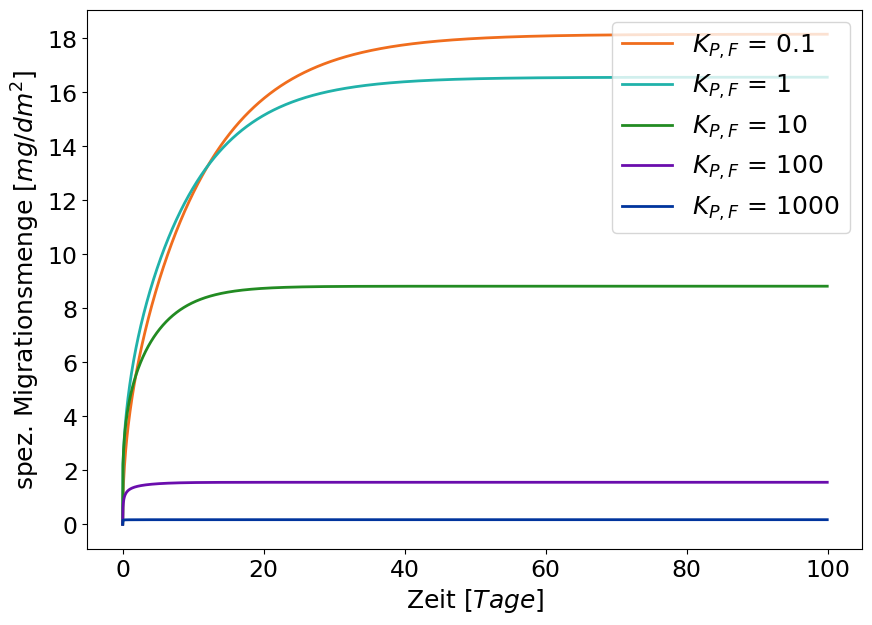

In [336]:
plt.figure(figsize=(10, 7))


colors = ['#00349D', '#6A0DAD', '#228B22', '#20B2AA', '#F06D1D']
colors = colors[::-1]

for i, K_PF in enumerate(K_values):
    results_area_K[i][0] = 0  # Erster Eintrag auf 0 setzen für Dartstellung
    plt.plot(time_days, results_area_K[i], label=f"$K_{{P,F}}$ = {K_PF}", linewidth = 2, color = colors[i])


# Unterschrift mit den Randbedingungen
# conditions_text = (
#     f"Material: {Material}, T = {T_C} °C\n"
#     f"$M_{{r}}$ = {M_mw} g/mol, $A_{{P}}^{{'}}$ = {A_Pt} \n"
#     f"$c_{{P,0}}$ = {c_P0} mg/kg, $\\rho_{{P}}$ = {P_density} g/cm³, $\\rho_{{F}}$ = {F_density} g/cm³\n"
#     f"$\\alpha$ = {alpha}\n"
#     f"$A_{{P,F}}$ = {A_PF} dm², $d_{{P}}$ = {d_P} cm, $d_{{F}}$ = {d_F} cm\n"
# )
# Füge den Text unterhalb des Plots hinzu
# plt.figtext(0.5, 0.33, conditions_text, wrap=True, horizontalalignment='left', fontsize=10, va='center')


y_ticks = np.arange(0, np.ceil(max([max(r) for r in results_area_K])) + 1, 2)  # Ganzen Zahlenbereich bestimmen

plt.xlabel('Zeit $[Tage]$', fontsize=18)  
plt.ylabel('spez. Migrationsmenge $[mg/dm^2]$', fontsize=18)  
plt.xticks(fontsize=17)  # Ticks der x-Achse
plt.yticks(y_ticks, fontsize=17)  # Ticks der y-Achse

plt.legend(loc='upper right', fontsize = 18)
plt.savefig('/Users/tomhartmann/Documents/00_UNI/01_MASTER/STUDIENARBEIT/000_Vektorgrafiken/Piringer/piringer-var-K.pdf', bbox_inches='tight')
plt.show()

# Migrationskurven

#### spez. Migration über die Zeit

In [334]:
# plt.figure(figsize = (10, 6))
# time_days = np.arange(0, max_time / (3600 * 24), timestep / (3600 * 24))
# plt.plot(time_days, results_percent_K[0])
# plt.title("Migration % ")
# plt.xlabel("Time $[days]$")
# plt.ylabel("Migrating amount [%]")
# plt.show()


In [335]:
# plt.figure(figsize = (10, 7))
# time_days = np.arange(0, max_time / (3600 * 24), timestep / (3600 * 24))
# plt.plot(time_days, results, label = "calc.")

# # Vergelich mit experimentellen Werten

# t_exp_2 = [1, 2, 4, 10]
# m_F_exp_2 = [0.85, 1.26, 1.74, 2.75]

# # t_exp_3 = [4, 10, 20]
# # m_F_exp_3 = [3.84, 6.06, 8.7]

# plt.scatter(t_exp_2, m_F_exp_2, color = "red", marker= '^', label= "exp.")
# plt.plot(t_exp_2, m_F_exp_2, color="red", linestyle='--')

# plt.title("Migration over time")
# plt.xlabel("Time $[days]$")
# plt.ylabel("Migrating amount $[mg/kg]$")
# plt.legend(loc="upper right")

# # Unterschrift mit den Randbedingungen
# conditions_text = (
#     f"Material: {Material} \n"
#     f"$T$ = {T_C} °C, $M_{{r}}$ = {M_mw} g/mol, $A_{{P}}^{{'}}$ = {A_Pt} \n"
#     f"$c_{{P,0}}$ = {c_P0} mg/kg, $\\rho_{{P}}$ = {P_density} g/cm³, $\\rho_{{F}}$ = {F_density} g/cm³\n"
#     f"$K_{{P,F}}$ = {K_PF}, $\\alpha$ = {alpha}\n"
#     f"$A_{{P,F}}$ = {A_PF} dm², $d_{{P}}$ = {d_P} cm, $d_{{F}}$ = {d_F} cm\n"
# )
# # Füge den Text unterhalb des Plots hinzu
# plt.figtext(0.75, 0.15, conditions_text, wrap=True, horizontalalignment='center', fontsize=10)

# # Layout anpassen und Plot anzeigen
# plt.tight_layout()
# plt.show()
# results[-1]